# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image
import pdb
import lmdb
import pickle
import six
import pyarrow as pa
import msgpack
import pandas as pd
import h5py

# Config

In [3]:
path_data = Path('data')

In [4]:
!ls {path_data}

cifar-10-batches-py


# Load pickle

In [5]:
path_cifar = path_data/'cifar-10-batches-py'

In [6]:
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [7]:
data_batches = [unpickle(path_cifar/('data_batch_' + str(i))) for i in range(1,5)]

Get labels, data, and filenames. Note that files are png by default

In [8]:
labels = np.concatenate([data_batch[b'labels'] for data_batch in data_batches])
labels.shape

(40000,)

In [9]:
data = np.concatenate([data_batch[b'data'] for data_batch in data_batches])
data.shape

(40000, 3072)

In [10]:
filenames = np.concatenate([data_batch[b'filenames'] for data_batch in data_batches])
filenames.shape

(40000,)

Format stuff

In [11]:
def _format_data(data):
    return np.transpose(data.reshape(3, 32, 32), (1, 2, 0))

imgs = np.stack([_format_data(d) for d in data])
imgs.shape

(40000, 32, 32, 3)

# Utility functions

In [12]:
def imresize(img, sz):
    return np.array(Image.fromarray(img).resize(sz))

In [13]:
def put_lmdb(path_lmdb, keys, vals, sz_block=None, saver=None, hook=None):
    path_lmdb.mkdir(parents=True, exist_ok=True)
    
    # Create database
    env = lmdb.open(path_lmdb.as_posix(), map_size=1.6e10)

    # Iterate in blocks, which is faster
    if sz_block is None:
        sz_block=len(data)
    
    # Get indices and then split into blocks
    idxs = np.arange(len(data))
    idx_blocks = np.split(idxs, np.ceil(len(data)/sz_block)) 
    for idx_block in idx_blocks:
        with env.begin(write=True) as txn:
            for idx in idx_block:
                key = keys[idx]
                val = vals[idx]
                
                if hook is not None:
                    hook(idx, key, val)

                if saver is not None:
                    val = saver(val)
                    
                txn.put(keys[idx].encode('ascii'), val)
                
    # Close environemnt
    env.close()

In [14]:
def get_lmdb(path_lmdb, keys, loader=None):
    env = lmdb.open(path_lmdb.as_posix(), readonly=True)

    # Read all values as a single transaction
    with env.begin() as txn:
        vals = [txn.get(key.encode('ascii')) for key in keys]
    
    # Close environment
    env.close()
    
    if loader is not None:
        vals = [loader(val) for val in vals]
    
    return vals

# Save images

Based on tests, processing becomes gpu constrained for images above 256x256, and also my laptop runs out of space, so don't bother with "large" (i.e. 512x512) size images

In [15]:
def _save_image(idx, dir_root, ext, sz=None):
    label = labels[idx]    
    img = imgs[idx]        
    filename = Path(filenames[idx].decode('UTF-8')).with_suffix('.' + ext)
    
    if sz is not None:
        img = imresize(img, sz)
    
    dir_label = dir_root/str(label)
    dir_label.mkdir(parents=True, exist_ok=True)
    
    if ext == 'raw':
        img.astype('int8').tofile(dir_label/filename)
    else:
        Image.fromarray(img).save(dir_label/filename, compress_level=0)

### small images

In [16]:
for ext in ['png', 'tif', 'jpg', 'raw']:
    path_root = path_data/'small_imgs'/ext
    Parallel(n_jobs=12)(delayed(_save_image)(i, path_root, ext) for i in tqdm(range(len(filenames))));

100%|██████████| 40000/40000 [00:01<00:00, 25610.94it/s]


### medium images

In [17]:
for ext in ['png', 'tif', 'jpg', 'raw']:
    path_root = path_data/'medium_imgs'/ext
    Parallel(n_jobs=8)(delayed(_save_image)(i, path_root, ext, (256, 256)) for i in tqdm(range(len(filenames))));

100%|██████████| 40000/40000 [00:09<00:00, 4337.28it/s]


# Save LMDB

In [18]:
def _saver_img(img, sz=None):
    if sz is not None:
        img = imresize(img, sz)  

    return pickle.dumps(img)

keys will be class_filename

### small images

In [19]:
path_lmdb = path_data/'small_lmdb'
keys = ['_'.join([str(cl), Path(f.decode('utf-8')).stem]) for (cl, f) in zip (labels, filenames)]
put_lmdb(path_lmdb/'lmdb',
         keys,
         imgs,
         saver=_saver_img)

pd.DataFrame({'label': labels,
              'filename': [Path(f.decode('utf-8')).stem for f in filenames],
              'key': keys}).to_csv(path_lmdb/'meta.csv', index=False)

### medium images

In [20]:
path_lmdb = path_data/'medium_lmdb'
keys = ['_'.join([str(cl), Path(f.decode('utf-8')).stem]) for (cl, f) in zip (labels, filenames)]
put_lmdb(path_lmdb/'lmdb',
         keys,
         imgs,
         sz_block=1000,
         saver=lambda x: _saver_img(x, (256, 256)))

pd.DataFrame({'label': labels,
              'filename': [Path(f.decode('utf-8')).stem for f in filenames],
              'key': keys}).to_csv(path_lmdb/'meta.csv', index=False)

# Save HDF5

### small images

In [21]:
path_hdf5 = path_data/'small_hdf5'
path_hdf5.mkdir(exist_ok=True)

with h5py.File(path_hdf5/'data.hdf5', 'w') as f:
    f.create_dataset('data', imgs.shape, imgs.dtype, data=imgs)
    
(pd.DataFrame({'label': labels,
               'filename': [Path(f.decode('utf-8')).stem for f in filenames]})
 .to_csv(path_hdf5/'meta.csv', index_label='idx'))

### medium images

In [22]:
path_hdf5 = path_data/'medium_hdf5'
path_hdf5.mkdir(exist_ok=True)

imgs_med = np.zeros((imgs.shape[0], 256, 256, imgs.shape[3]), dtype=np.uint8)
for idx, img in enumerate(imgs):
    imgs_med[idx] = imresize(img, (256, 256))
    
with h5py.File(path_hdf5/'data.hdf5', 'w') as f:
    f.create_dataset('data', imgs_med.shape, imgs_med.dtype, data=imgs_med)

del imgs_med

(pd.DataFrame({'label': labels,
               'filename': [Path(f.decode('utf-8')).stem for f in filenames]})
 .to_csv(path_hdf5/'meta.csv', index_label='idx'))

# Test

In [23]:
filename = 'cassowary_s_001300'
label = '2'
size = 'medium'

### Load image

In [24]:
def _open_path(path_img):
    if path_img.suffix == '.raw':
        img = np.fromfile(path_img, dtype='uint8')
        sz = int(np.sqrt(img.size/3))
        img = Image.fromarray(img.reshape(sz, sz, 3))
    else:
        img = Image.open(path_img)
        
    return img

In [25]:
ext = 'png'

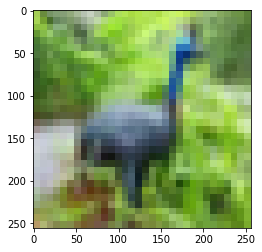

In [26]:
path_file = path_data/(size + '_imgs')/ext/label/(filename + '.' + ext)
plt.imshow(_open_path(path_file))

### Load lmdb

In [27]:
def _open_lmdb(path_lmdb, label, filename):        
    return Image.fromarray(get_lmdb(path_lmdb,
                           [label + '_' + filename], # Key is label_filename
                           pickle.loads)[0])

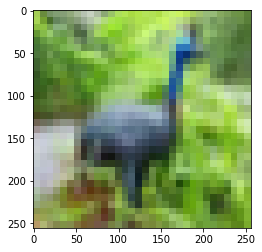

In [28]:
path_lmdb = path_data/(size  + '_lmdb')/'lmdb'
plt.imshow(_open_lmdb(path_lmdb, label, filename))

### Load hdf5

In [29]:
def _open_hdf5(path_hdf5, label, filename):
    # Must find index given a label and filename
    df_meta = pd.read_csv(path_hdf5/'meta.csv')
    info = df_meta[(df_meta.label == int(label)) & (df_meta.filename == filename)]
    with h5py.File(path_hdf5/'data.hdf5', "r") as f:
        img = f['data'][info['idx']]
    return Image.fromarray(img)

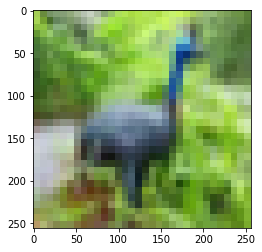

In [30]:
path_hdf5 = path_data/(size + '_hdf5')
plt.imshow(_open_hdf5(path_hdf5, label, filename))